# Assistants 

[Assistants](https://langchain-ai.github.io/langgraph/concepts/assistants/#resources) give developers a quick and easy way to modify and version agents for experimentation.

## Supplying configuration to the graph

Our `task_maistro` graph is already set up to use assistants!

It has a `configuration.py` file defined and loaded in the graph.

We access configurable fields (`user_id`, `todo_category`, `task_maistro_role`) inside the graph nodes.

## Creating assistants 

Now, what is a practical use-case for assistants with the `task_maistro` app that we've been building?

For me, it's the ability to have separate ToDo lists for different categories of tasks. 

For example, I want one assistant for my personal tasks and another for my work tasks.

These are easily configurable using the `todo_category` and `task_maistro_role` configurable fields.

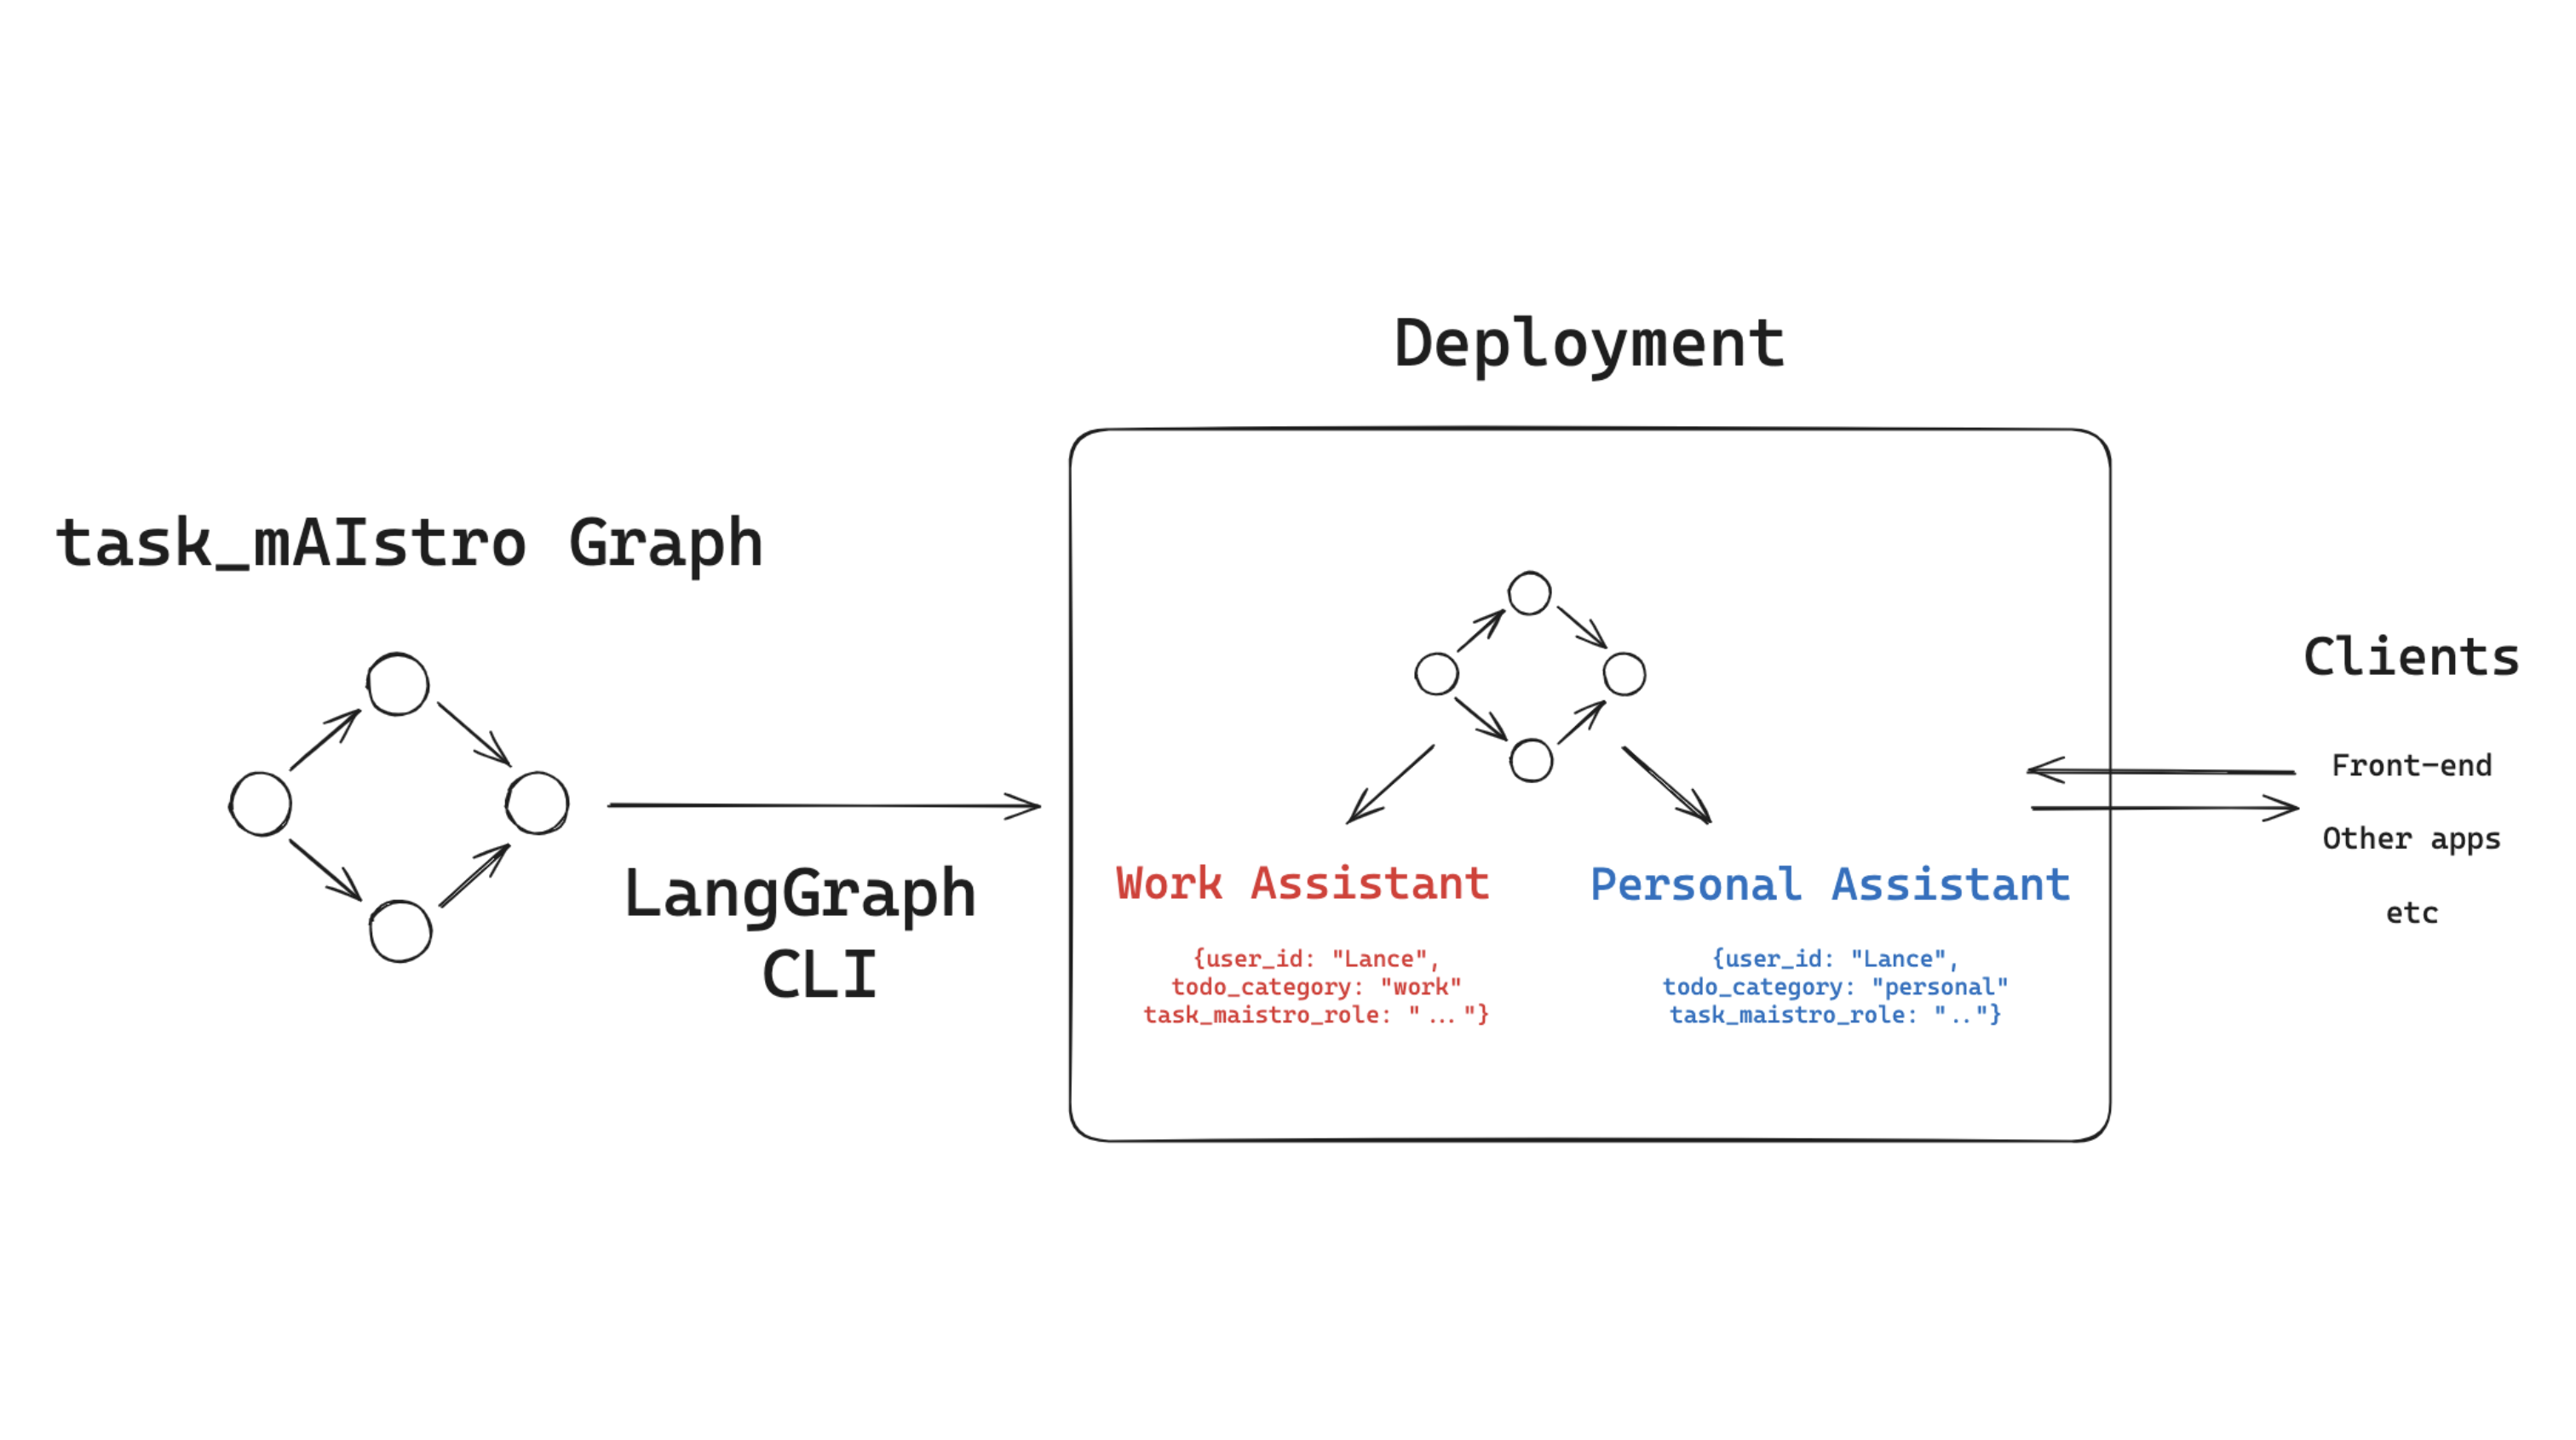

In [ ]:
%%capture --no-stderr
%pip install -U langgraph_sdk

This is the default assistant that we created when we deployed the graph.

In [12]:
from langgraph_sdk import get_client
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)

### Personal assistant

This is the personal assistant that I'll use to manage my personal tasks.

In [13]:
personal_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro", 
    config={"configurable": {"todo_category": "personal"}}
)
print(personal_assistant)

{'assistant_id': '4f83d674-22d8-4225-abe1-017ad1bc9f99', 'graph_id': 'task_maistro', 'created_at': '2024-11-15T18:20:05.930670+00:00', 'updated_at': '2024-11-15T18:20:05.930670+00:00', 'config': {'configurable': {'todo_category': 'personal'}}, 'metadata': {}, 'version': 1, 'name': 'Untitled'}


Let's update this assistant to include my `user_id` for convenience, [creating a new version of it](https://langchain-ai.github.io/langgraph/cloud/how-tos/assistant_versioning/#create-a-new-version-for-your-assistant). 

In [14]:
task_maistro_role = """You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:

- Help track and organize personal tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- Proactively ask for deadlines when new tasks are added without them
- Maintain a supportive tone while helping the user stay accountable
- Help prioritize tasks based on deadlines and importance

Your communication style should be encouraging and helpful, never judgmental. 

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Would you like to add one to help us track it better?"""

configurations = {"todo_category": "personal", 
                  "user_id": "lance",
                  "task_maistro_role": task_maistro_role}

personal_assistant = await client.assistants.update(
    personal_assistant["assistant_id"],
    config={"configurable": configurations}
)
print(personal_assistant)

{'assistant_id': '4f83d674-22d8-4225-abe1-017ad1bc9f99', 'graph_id': 'task_maistro', 'created_at': '2024-11-15T18:21:52.073556+00:00', 'updated_at': '2024-11-15T18:21:52.073556+00:00', 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'personal', 'task_maistro_role': 'You are a friendly and organized personal task assistant. Your main focus is helping users stay on top of their personal tasks and commitments. Specifically:\n\n- Help track and organize personal tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- Proactively ask for deadlines when new tasks are added without them\n- Maintain a supportive tone while helping the user stay accountable\n- Help prioritize tasks based on deadlines and importance\n\nYour communication style should be encouraging

### Work assistant

Now, let's create a work assistant. I'll use this for my work tasks.

In [15]:
task_maistro_role = """You are a focused and efficient work task assistant. 

Your main focus is helping users manage their work commitments with realistic timeframes. 

Specifically:

- Help track and organize work tasks
- When providing a 'todo summary':
  1. List all current tasks grouped by deadline (overdue, today, this week, future)
  2. Highlight any tasks missing deadlines and gently encourage adding them
  3. Note any tasks that seem important but lack time estimates
- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:
  • Developer Relations features: typically 1 day
  • Course lesson reviews/feedback: typically 2 days
  • Documentation sprints: typically 3 days
- Help prioritize tasks based on deadlines and team dependencies
- Maintain a professional tone while helping the user stay accountable

Your communication style should be supportive but practical. 

When tasks are missing deadlines, respond with something like "I notice [task] doesn't have a deadline yet. Based on similar tasks, this might take [suggested timeframe]. Would you like to set a deadline with this in mind?"""

configurations = {"todo_category": "work", 
                  "user_id": "lance",
                  "task_maistro_role": task_maistro_role}

work_assistant = await client.assistants.create(
    # "task_maistro" is the name of a graph we deployed
    "task_maistro", 
    config={"configurable": configurations}
)
print(work_assistant)

{'assistant_id': '34f27dd0-2e9d-47f3-aa6d-06cb7ac625fc', 'graph_id': 'task_maistro', 'created_at': '2024-11-15T18:23:05.039052+00:00', 'updated_at': '2024-11-15T18:23:05.039052+00:00', 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'work', 'task_maistro_role': 'You are a focused and efficient work task assistant. \n\nYour main focus is helping users manage their work commitments with realistic timeframes. \n\nSpecifically:\n\n- Help track and organize work tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:\n  • Developer Relations features: typically 1 day\n  • Course lesson reviews/feedback: typically 2 days\n  • Documentation sprints: typically 3 day

## Using assistants 

Assistants will be saved to `Postgres` in our deployment.  

This allows us to easily search [search](https://langchain-ai.github.io/langgraph/cloud/how-tos/configuration_cloud/) for assistants with the SDK.

In [16]:
assistants = await client.assistants.search()
for assistant in assistants:
    print({
        'assistant_id': assistant['assistant_id'],
        'version': assistant['version'],
        'config': assistant['config']
    })

{'assistant_id': '34f27dd0-2e9d-47f3-aa6d-06cb7ac625fc', 'version': 1, 'config': {'configurable': {'user_id': 'lance', 'todo_category': 'work', 'task_maistro_role': 'You are a focused and efficient work task assistant. \n\nYour main focus is helping users manage their work commitments with realistic timeframes. \n\nSpecifically:\n\n- Help track and organize work tasks\n- When providing a \'todo summary\':\n  1. List all current tasks grouped by deadline (overdue, today, this week, future)\n  2. Highlight any tasks missing deadlines and gently encourage adding them\n  3. Note any tasks that seem important but lack time estimates\n- When discussing new tasks, suggest that the user provide realistic time-frames based on task type:\n  • Developer Relations features: typically 1 day\n  • Course lesson reviews/feedback: typically 2 days\n  • Documentation sprints: typically 3 days\n- Help prioritize tasks based on deadlines and team dependencies\n- Maintain a professional tone while helping 

We can manage them easily with the SDK. For example, we can delete assistants that we're no longer using.

In [51]:
await client.assistants.delete("assistant_id")

Let's set the assistant IDs for the `personal` and `work` assistants that I'll work with.

In [19]:
work_assistant_id = assistants[0]['assistant_id']
personal_assistant_id = assistants[1]['assistant_id']

### Work assistant

Let's add some ToDos for my work assistant.

In [20]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import convert_to_messages

user_input = "Create or update few ToDos: 1) Re-film Module 6, lesson 5 by end of day today. 2) Update audioUX by next Monday."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create or update few ToDos: 1) Re-film Module 6, lesson 5 by end of day today. 2) Update audioUX by next Monday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_jLkeZj3YIMAU0C0iGfsk0PXK)
 Call ID: call_jLkeZj3YIMAU0C0iGfsk0PXK
  Args:
    update_type: todo
================================= Tool Message =================================

Document b162a63a-5579-4d75-b943-e0747cc40e7e updated:
Plan: Update the deadline for the task 'Re-film Module 6, lesson 5' to the end of today, which is 2024-11-15T23:59:59.
Added content: 2024-11-15T23:59:59

Document cacce3f2-2690-4b67-bf59-b3ce85e36a07 updated:
Plan: Update the deadline for the task 'Update audioUX repo' to next Monday, which is 2024-11-18T23:59:59.
Added content: 2024-11-18T23:59:59
================================== Ai Message ==================================

I've updated the deadlin

In [21]:
user_input = "Create another ToDo: Finalize set of report generation tutorials."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create another ToDo: Finalize set of report generation tutorials.
================================== Ai Message ==================================

Could you provide a deadline for finalizing the set of report generation tutorials? Based on similar tasks, this might take around 2 days. Would you like to set a deadline with this in mind?


The assistant uses it's instructions to push back with task creation! 

It asks me to specify a deadline :) 

In [22]:
user_input = "OK, for this task let's get it done by next Tuesday."
async for chunk in client.runs.stream(thread["thread_id"], 
                                      work_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

OK, for this task let's get it done by next Tuesday.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_z5mz51DfFd7Akjacgxo5xhCB)
 Call ID: call_z5mz51DfFd7Akjacgxo5xhCB
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Finalize set of report generation tutorials', 'time_to_complete': 960, 'deadline': '2024-11-21T23:59:59', 'solutions': ['Review existing tutorial drafts', 'Incorporate feedback from peer reviews', 'Ensure all tutorials are consistent in style and format', 'Test each tutorial to ensure accuracy', 'Prepare final versions for publication'], 'status': 'not started'}
================================== Ai Message ==================================

I've updated the deadline for finalizing the set of report generation tutorials to next T

### Personal assistant

Similarly, we can add ToDos for my personal assistant.

In [23]:
user_input = "Create ToDos: 1) Check on swim lessons for the baby this weekend. 2) For winter travel, check AmEx points."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Create ToDos: 1) Check on swim lessons for the baby this weekend. 2) For winter travel, check AmEx points.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_qg6BJTH3WLd1OMwUOejH3brs)
 Call ID: call_qg6BJTH3WLd1OMwUOejH3brs
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Check on swim lessons for the baby this weekend', 'time_to_complete': 30, 'deadline': '2024-11-17T23:59:59', 'solutions': ['Call the local swimming pool', 'Check online for available classes', 'Confirm the schedule and fees'], 'status': 'not started'}

New ToDo created:
Content: {'task': 'For winter travel, check AmEx points', 'time_to_complete': 20, 'deadline': '2024-11-19T23:59:59', 'solutions': ['Log into AmEx account', 'Check points balance', 'Explore travel redemption opti

In [24]:
user_input = "Give me a todo summary."
thread = await client.threads.create()
async for chunk in client.runs.stream(thread["thread_id"], 
                                      personal_assistant_id,
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      stream_mode="values"):

    if chunk.event == 'values':
        state = chunk.data
        convert_to_messages(state["messages"])[-1].pretty_print()

================================ Human Message =================================

Give me a todo summary.
================================== Ai Message ==================================

Here's your current to-do summary:

**Overdue Tasks:**
- None! Great job staying on top of things.

**Tasks for Today:**
- None scheduled for today.

**Tasks for This Week:**
- **Check on swim lessons for the baby this weekend** (Deadline: November 17, 2024)
  - Estimated time to complete: 30 minutes
  - Solutions: Call the local swimming pool, check online for available classes, confirm the schedule and fees.
  
- **For winter travel, check AmEx points** (Deadline: November 19, 2024)
  - Estimated time to complete: 20 minutes
  - Solutions: Log into AmEx account, check points balance, explore travel redemption options.
  
- **Finish booking winter travel** (Deadline: November 19, 2024)
  - Estimated time to complete: 120 minutes
  - Solutions: Compare flight prices, check accommodation options, final